<a href="https://colab.research.google.com/github/ADRIANVM117/data-science-portfolio/blob/main/AMZN_STOCK_STATS_AND_PREDICTIVE_MODEL/LSTM_5MIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import requests
import pandas as pd

def obtener_indicadores_trading(symbol='AMZN', api_key='tu_api_key'):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos  100 datos intradia
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&entitlement=delayed&apikey={api_key}'

    r = requests.get(url_time_series)
    data = r.json()

    # Extraer los datos de 'Time Series (5min)'
    time_series = data['Time Series (5min)']

    # Convertir los datos en un DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Renombrar las columnas para mayor claridad
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convertir el índice a formato datetime
    df.index = pd.to_datetime(df.index)

    # Realizar la solicitud a la API para obtener el SMA
    url_sma = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=5min&time_period=10&series_type=close&entitlement=delayed&apikey={api_key}'

    r = requests.get(url_sma)
    data_sma = r.json()

    # Extraer los datos de 'Technical Analysis: SMA'
    sma_data = data_sma['Technical Analysis: SMA']

    # Convertir los datos del SMA en un DataFrame
    df_sma = pd.DataFrame.from_dict(sma_data, orient='index')

    # Renombrar la columna SMA
    df_sma.columns = ['SMA']

    # Convertir el índice a formato datetime
    df_sma.index = pd.to_datetime(df_sma.index)

    # Unir los DataFrames df y df_sma a través del índice
    df_combined = pd.merge(df, df_sma, left_index=True, right_index=True, how='inner')

    # Cambiar columnas de tipo object a float
    df_combined['Open'] = df_combined['Open'].astype(float)
    df_combined['High'] = df_combined['High'].astype(float)
    df_combined['Low'] = df_combined['Low'].astype(float)
    df_combined['Close'] = df_combined['Close'].astype(float)
    df_combined['Volume'] = df_combined['Volume'].astype(float)
    df_combined['SMA'] = df_combined['SMA'].astype(float)

    # Calcular indicadores adicionales

    # Media Móvil Exponencial (EMA)
    df_combined['EMA'] = df_combined['Close'].ewm(span=10, adjust=False).mean()
    df_combined['SMA_vs_EMA'] = df_combined['SMA'] - df_combined['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df_combined['TR'] = df_combined['High'] - df_combined['Low']
    df_combined['ATR'] = df_combined['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df_combined['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df_combined['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df_combined['Rolling Mean'] = df_combined['Close'].rolling(window=20).mean()
    df_combined['Rolling Std'] = df_combined['Close'].rolling(window=20).std()
    df_combined['Upper Band'] = df_combined['Rolling Mean'] + (df_combined['Rolling Std'] * 2)
    df_combined['Lower Band'] = df_combined['Rolling Mean'] - (df_combined['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df_combined['14 High'] = df_combined['High'].rolling(window=14).max()
    df_combined['14 Low'] = df_combined['Low'].rolling(window=14).min()
    df_combined['%K'] = (df_combined['Close'] - df_combined['14 Low']) / (df_combined['14 High'] - df_combined['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df_combined['Momentum'] = df_combined['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df_combined['Typical Price'] = (df_combined['High'] + df_combined['Low'] + df_combined['Close']) / 3
    df_combined['CCI'] = (df_combined['Typical Price'] - df_combined['Typical Price'].rolling(window=20).mean()) / (0.015 * df_combined['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df_combined['EMA12'] = df_combined['Close'].ewm(span=12, adjust=False).mean()
    df_combined['EMA26'] = df_combined['Close'].ewm(span=26, adjust=False).mean()
    df_combined['MACD'] = df_combined['EMA12'] - df_combined['EMA26']
    df_combined['MACD Signal'] = df_combined['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df_combined['Volume Average'] = df_combined['Volume'].rolling(window=14).mean()
    df_combined.fillna(0, inplace=True)  # 🔄 Reemplaza NaN con 0 en todo el DataFrame


    return df_combined

# Llamar la función con el símbolo y tu API key
df_final_1 = obtener_indicadores_trading(symbol='AMZN', api_key='#####')
df_final_1

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-02-04 13:50:00,241.985,242.05,241.740,241.8600,84388.0,241.4555,241.860000,-0.404500,0.310,0.000000,...,0.00,0.000000,0.000000,241.883333,0.000000,241.860000,241.860000,0.000000,0.000000,0.000000
2025-02-04 13:45:00,241.890,242.05,241.810,241.9801,130833.0,241.3855,241.881836,-0.496336,0.240,0.000000,...,0.00,0.000000,0.000000,241.946700,0.000000,241.878477,241.868896,0.009581,0.001916,0.000000
2025-02-04 13:40:00,241.570,241.90,241.570,241.8968,243416.0,241.3595,241.884557,-0.525057,0.330,0.000000,...,0.00,0.000000,0.000000,241.788933,0.000000,241.881296,241.870963,0.010333,0.003599,0.000000
2025-02-04 13:35:00,241.655,241.79,241.520,241.5700,141578.0,241.3246,241.827365,-0.502765,0.270,0.000000,...,0.00,0.000000,0.000000,241.626667,0.000000,241.833404,241.848670,-0.015265,-0.000174,0.000000
2025-02-04 13:30:00,241.240,241.70,241.215,241.6400,134817.0,241.3046,241.793299,-0.488699,0.485,0.000000,...,0.00,0.000000,0.000000,241.518333,0.000000,241.803650,241.833213,-0.029563,-0.006051,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 05:55:00,237.300,237.30,237.200,237.2900,818.0,237.2290,237.790098,-0.561098,0.100,0.345714,...,236.96,17.098446,-0.006032,237.263333,-112.461567,237.877254,238.269660,-0.392405,-0.275848,3677.285714
2025-02-04 05:50:00,237.250,237.25,237.210,237.2500,91.0,237.2170,237.691899,-0.474899,0.040,0.317857,...,236.96,15.025907,0.000506,237.236667,-101.794314,237.780754,238.194129,-0.413376,-0.303353,3550.857143
2025-02-04 05:45:00,237.240,237.30,237.200,237.3000,946.0,237.2040,237.620644,-0.416644,0.100,0.316429,...,236.96,17.616580,-0.000379,237.266667,-88.197904,237.706792,238.127898,-0.421106,-0.326904,3563.500000
2025-02-04 05:40:00,236.990,237.28,236.960,237.2800,185.0,237.1740,237.558709,-0.384709,0.320,0.315000,...,236.96,16.580311,-0.000590,237.173333,-88.564074,237.641131,238.065090,-0.423959,-0.346315,3458.857143


In [51]:
import requests
import pandas as pd

def obtener_indicadores_trading(symbol='AMZN', api_key='tu_api_key'):
    # Realizar la solicitud a la API para obtener los datos de la serie temporal de 5 minutos de los últimos 30 días
    url_time_series = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&outputsize=full&apikey={api_key}'

    r = requests.get(url_time_series)
    data = r.json()

    # Extraer los datos de 'Time Series (5min)'
    time_series = data['Time Series (5min)']

    # Convertir los datos en un DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Renombrar las columnas para mayor claridad
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Convertir el índice a formato datetime
    df.index = pd.to_datetime(df.index)

    # Realizar la solicitud a la API para obtener el SMA
    url_sma = f'https://www.alphavantage.co/query?function=SMA&symbol={symbol}&interval=5min&time_period=10&series_type=close&outputsize=full&apikey={api_key}'

    r = requests.get(url_sma)
    data_sma = r.json()

    # Extraer los datos de 'Technical Analysis: SMA'
    sma_data = data_sma['Technical Analysis: SMA']

    # Convertir los datos del SMA en un DataFrame
    df_sma = pd.DataFrame.from_dict(sma_data, orient='index')

    # Renombrar la columna SMA
    df_sma.columns = ['SMA']

    # Convertir el índice a formato datetime
    df_sma.index = pd.to_datetime(df_sma.index)

    # Unir los DataFrames df y df_sma a través del índice
    df_combined = pd.merge(df, df_sma, left_index=True, right_index=True, how='inner')

    # Cambiar columnas de tipo object a float
    df_combined['Open'] = df_combined['Open'].astype(float)
    df_combined['High'] = df_combined['High'].astype(float)
    df_combined['Low'] = df_combined['Low'].astype(float)
    df_combined['Close'] = df_combined['Close'].astype(float)
    df_combined['Volume'] = df_combined['Volume'].astype(float)
    df_combined['SMA'] = df_combined['SMA'].astype(float)

    # Calcular indicadores adicionales

    # Media Móvil Exponencial (EMA)
    df_combined['EMA'] = df_combined['Close'].ewm(span=10, adjust=False).mean()
    df_combined['SMA_vs_EMA'] = df_combined['SMA'] - df_combined['EMA']

    # Rango Verdadero (TR) y ATR (Average True Range)
    df_combined['TR'] = df_combined['High'] - df_combined['Low']
    df_combined['ATR'] = df_combined['TR'].rolling(window=14).mean()  # Media móvil de 14 días

    # RSI (Relative Strength Index)
    delta = df_combined['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()  # Ganancia promedio
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()  # Pérdida promedio
    rs = gain / loss
    df_combined['RSI'] = 100 - (100 / (1 + rs))

    # Bandas de Bollinger
    df_combined['Rolling Mean'] = df_combined['Close'].rolling(window=20).mean()
    df_combined['Rolling Std'] = df_combined['Close'].rolling(window=20).std()
    df_combined['Upper Band'] = df_combined['Rolling Mean'] + (df_combined['Rolling Std'] * 2)
    df_combined['Lower Band'] = df_combined['Rolling Mean'] - (df_combined['Rolling Std'] * 2)

    # Oscilador Estocástico (Stochastic Oscillator)
    df_combined['14 High'] = df_combined['High'].rolling(window=14).max()
    df_combined['14 Low'] = df_combined['Low'].rolling(window=14).min()
    df_combined['%K'] = (df_combined['Close'] - df_combined['14 Low']) / (df_combined['14 High'] - df_combined['14 Low']) * 100

    # Momentum (Tasa de cambio)
    df_combined['Momentum'] = df_combined['Close'].pct_change(periods=5)  # Cambio porcentual en 5 periodos

    # Índice de Canal de Materias Primas (CCI)
    df_combined['Typical Price'] = (df_combined['High'] + df_combined['Low'] + df_combined['Close']) / 3
    df_combined['CCI'] = (df_combined['Typical Price'] - df_combined['Typical Price'].rolling(window=20).mean()) / (0.015 * df_combined['Typical Price'].rolling(window=20).std())

    # MACD (Moving Average Convergence Divergence)
    df_combined['EMA12'] = df_combined['Close'].ewm(span=12, adjust=False).mean()
    df_combined['EMA26'] = df_combined['Close'].ewm(span=26, adjust=False).mean()
    df_combined['MACD'] = df_combined['EMA12'] - df_combined['EMA26']
    df_combined['MACD Signal'] = df_combined['MACD'].ewm(span=9, adjust=False).mean()

    # Promedio de Volumen
    df_combined['Volume Average'] = df_combined['Volume'].rolling(window=14).mean()
    df_combined.fillna(0, inplace=True)  # 🔄 Reemplaza NaN con 0 en todo el DataFrame


    return df_combined

# Llamar la función con el símbolo y tu API key
df_final_2 = obtener_indicadores_trading(symbol='AMZN', api_key='#####')
df_final_2

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-02-03 19:55:00,238.75,239.0200,238.75,238.9900,2852.0,238.744,238.990000,-0.246000,0.2700,0.000000,...,0.00,0.000000,0.000000,238.920000,0.000000,238.990000,238.990000,0.000000,0.000000,0.000000
2025-02-03 19:50:00,238.98,238.9800,238.75,238.8699,3638.0,238.723,238.968164,-0.245164,0.2300,0.000000,...,0.00,0.000000,0.000000,238.866633,0.000000,238.971523,238.981104,-0.009581,-0.001916,0.000000
2025-02-03 19:45:00,238.99,238.9900,238.75,238.7800,2757.0,238.686,238.933952,-0.247952,0.2400,0.000000,...,0.00,0.000000,0.000000,238.840000,0.000000,238.942058,238.966207,-0.024149,-0.006363,0.000000
2025-02-03 19:40:00,238.84,238.9900,238.75,238.9900,2594.0,238.701,238.944143,-0.243143,0.2400,0.000000,...,0.00,0.000000,0.000000,238.910000,0.000000,238.949434,238.967970,-0.018536,-0.008797,0.000000
2025-02-03 19:35:00,238.88,238.9899,238.65,238.8650,1235.0,238.672,238.929753,-0.257753,0.3399,0.000000,...,0.00,0.000000,0.000000,238.834967,0.000000,238.936444,238.960342,-0.023898,-0.011818,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-06 05:05:00,225.73,225.7700,225.69,225.7700,1435.0,225.774,226.050179,-0.276179,0.0800,0.185714,...,225.68,9.278351,-0.000575,225.743333,-104.834474,226.098432,226.334229,-0.235797,-0.184286,3201.428571
2025-01-06 05:00:00,225.73,225.7900,225.69,225.7000,2008.0,225.760,225.986510,-0.226510,0.1000,0.178571,...,225.68,2.298851,-0.000797,225.726667,-97.653334,226.037134,226.287249,-0.250114,-0.197452,3260.142857
2025-01-06 04:55:00,225.65,225.7500,225.65,225.7500,4542.0,225.731,225.943509,-0.212509,0.1000,0.172857,...,225.65,12.048193,-0.001106,225.716667,-91.624622,225.992960,226.247453,-0.254493,-0.208860,3487.142857
2025-01-06 04:50:00,225.74,225.7700,225.65,225.6500,2933.0,225.711,225.890143,-0.179143,0.1200,0.152143,...,225.65,0.000000,-0.001328,225.690000,-89.037239,225.940197,226.203197,-0.263000,-0.219688,2781.428571


In [52]:
import pandas as pd

# Supongamos que tus DataFrames son df1 y df2
df_final = pd.concat([df_final_1, df_final_2])

# Ordenar por índice (fecha) en orden cronológico si es necesario
df_final = df_final.sort_index()

# Mostrar resultado
df_final


,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-01-06 04:45:00,225.670,225.74,225.640,225.7400,1129.0,225.7170,225.862845,-0.145845,0.100,0.153571,...,225.64,11.904762,-0.000797,225.706667,-80.372145,225.909397,226.168886,-0.259489,-0.227648,2623.500000
2025-01-06 04:50:00,225.740,225.77,225.650,225.6500,2933.0,225.7110,225.890143,-0.179143,0.120,0.152143,...,225.65,0.000000,-0.001328,225.690000,-89.037239,225.940197,226.203197,-0.263000,-0.219688,2781.428571
2025-01-06 04:55:00,225.650,225.75,225.650,225.7500,4542.0,225.7310,225.943509,-0.212509,0.100,0.172857,...,225.65,12.048193,-0.001106,225.716667,-91.624622,225.992960,226.247453,-0.254493,-0.208860,3487.142857
2025-01-06 05:00:00,225.730,225.79,225.690,225.7000,2008.0,225.7600,225.986510,-0.226510,0.100,0.178571,...,225.68,2.298851,-0.000797,225.726667,-97.653334,226.037134,226.287249,-0.250114,-0.197452,3260.142857
2025-01-06 05:05:00,225.730,225.77,225.690,225.7700,1435.0,225.7740,226.050179,-0.276179,0.080,0.185714,...,225.68,9.278351,-0.000575,225.743333,-104.834474,226.098432,226.334229,-0.235797,-0.184286,3201.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 13:30:00,241.240,241.70,241.215,241.6400,134817.0,241.3046,241.793299,-0.488699,0.485,0.000000,...,0.00,0.000000,0.000000,241.518333,0.000000,241.803650,241.833213,-0.029563,-0.006051,0.000000
2025-02-04 13:35:00,241.655,241.79,241.520,241.5700,141578.0,241.3246,241.827365,-0.502765,0.270,0.000000,...,0.00,0.000000,0.000000,241.626667,0.000000,241.833404,241.848670,-0.015265,-0.000174,0.000000
2025-02-04 13:40:00,241.570,241.90,241.570,241.8968,243416.0,241.3595,241.884557,-0.525057,0.330,0.000000,...,0.00,0.000000,0.000000,241.788933,0.000000,241.881296,241.870963,0.010333,0.003599,0.000000
2025-02-04 13:45:00,241.890,242.05,241.810,241.9801,130833.0,241.3855,241.881836,-0.496336,0.240,0.000000,...,0.00,0.000000,0.000000,241.946700,0.000000,241.878477,241.868896,0.009581,0.001916,0.000000


In [44]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3739 entries, 2025-01-06 04:45:00 to 2025-02-04 13:40:00
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            3739 non-null   float64
 1   High            3739 non-null   float64
 2   Low             3739 non-null   float64
 3   Close           3739 non-null   float64
 4   Volume          3739 non-null   float64
 5   SMA             3739 non-null   float64
 6   EMA             3739 non-null   float64
 7   SMA_vs_EMA      3739 non-null   float64
 8   TR              3739 non-null   float64
 9   ATR             3739 non-null   float64
 10  RSI             3739 non-null   float64
 11  Rolling Mean    3739 non-null   float64
 12  Rolling Std     3739 non-null   float64
 13  Upper Band      3739 non-null   float64
 14  Lower Band      3739 non-null   float64
 15  14 High         3739 non-null   float64
 16  14 Low          3739 non-null   float64
 1

In [53]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar el escalador
scaler = MinMaxScaler()

# Escalar todas las columnas
df_final = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns, index=df_final.index)

# Ahora usar df_scaled en lugar de df_final
df_final

,Open,High,Low,Close,Volume,SMA,EMA,SMA_vs_EMA,TR,ATR,...,14 Low,%K,Momentum,Typical Price,CCI,EMA12,EMA26,MACD,MACD Signal,Volume Average
2025-01-06 04:45:00,0.371589,0.277070,0.716648,0.375957,0.000064,0.376156,0.380284,0.313809,0.002597,0.033418,...,0.934403,0.119048,0.314853,0.520839,0.358657,0.382235,0.390975,0.302534,0.297923,0.001540
2025-01-06 04:50:00,0.374206,0.277901,0.716819,0.372597,0.000166,0.375928,0.381325,0.310671,0.003174,0.033107,...,0.934444,0.000000,0.304355,0.520382,0.343312,0.383413,0.392306,0.301737,0.299976,0.001633
2025-01-06 04:55:00,0.370841,0.277347,0.716819,0.376330,0.000257,0.376688,0.383360,0.307526,0.002597,0.037614,...,0.934444,0.120482,0.308734,0.521113,0.338730,0.385431,0.394022,0.303668,0.302769,0.002047
2025-01-06 05:00:00,0.373832,0.278455,0.717501,0.374463,0.000113,0.377790,0.384999,0.306206,0.002597,0.038858,...,0.934568,0.022989,0.314850,0.521388,0.328054,0.387121,0.395566,0.304662,0.305711,0.001914
2025-01-06 05:05:00,0.373832,0.277901,0.717501,0.377077,0.000081,0.378322,0.387427,0.301524,0.002020,0.040412,...,0.934568,0.092784,0.319227,0.521845,0.315337,0.389466,0.397388,0.307912,0.309106,0.001879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 13:30:00,0.953645,0.719273,0.982342,0.969573,0.007649,0.968476,0.987775,0.281493,0.013705,0.000000,...,0.000000,0.000000,0.330605,0.954582,0.500985,0.990210,0.998536,0.354727,0.355072,0.000000
2025-02-04 13:35:00,0.969159,0.721767,0.987545,0.966959,0.008032,0.969236,0.989074,0.280167,0.007501,0.000000,...,0.000000,0.000000,0.330605,0.957554,0.500985,0.991348,0.999135,0.357972,0.356588,0.000000
2025-02-04 13:40:00,0.965981,0.724814,0.988398,0.979160,0.013811,0.970562,0.991255,0.278066,0.009233,0.000000,...,0.000000,0.000000,0.330605,0.962005,0.500985,0.993180,1.000000,0.363783,0.357561,0.000000
2025-02-04 13:45:00,0.977944,0.728970,0.992492,0.982270,0.007423,0.971550,0.991151,0.280773,0.006636,0.000000,...,0.000000,0.000000,0.330605,0.966333,0.500985,0.993073,0.999920,0.363612,0.357127,0.000000


Epoch 1/50 - Train Loss: 0.022624, Val Loss: 0.001284
Epoch 2/50 - Train Loss: 0.001018, Val Loss: 0.000765
Epoch 3/50 - Train Loss: 0.000688, Val Loss: 0.000577
Epoch 4/50 - Train Loss: 0.000530, Val Loss: 0.000888
Epoch 5/50 - Train Loss: 0.000484, Val Loss: 0.001345
Epoch 6/50 - Train Loss: 0.000522, Val Loss: 0.000795
Epoch 7/50 - Train Loss: 0.000348, Val Loss: 0.000444
Epoch 8/50 - Train Loss: 0.000352, Val Loss: 0.000472
Epoch 9/50 - Train Loss: 0.000299, Val Loss: 0.000979
Epoch 10/50 - Train Loss: 0.000344, Val Loss: 0.000725
Epoch 11/50 - Train Loss: 0.000276, Val Loss: 0.000607
Epoch 12/50 - Train Loss: 0.000363, Val Loss: 0.001009
Epoch 13/50 - Train Loss: 0.000299, Val Loss: 0.000627
Epoch 14/50 - Train Loss: 0.000387, Val Loss: 0.000547
Epoch 15/50 - Train Loss: 0.000289, Val Loss: 0.000829
Epoch 16/50 - Train Loss: 0.000282, Val Loss: 0.000581
Epoch 17/50 - Train Loss: 0.000247, Val Loss: 0.000561
Epoch 18/50 - Train Loss: 0.000263, Val Loss: 0.000968
Epoch 19/50 - Train

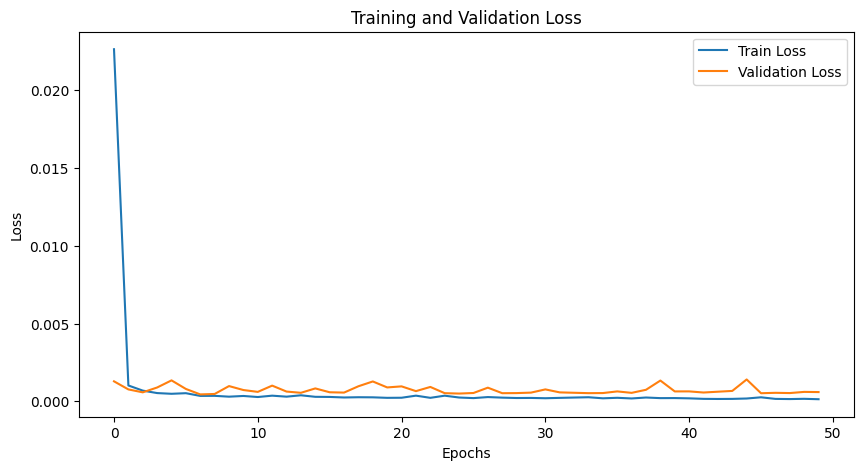

Predicción del precio en los próximos 5 minutos: 241.24
RMSE: 0.0238
MAE: 0.0162


In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 📌 1. Preparación de los Datos (X = Features, Y = Objetivo)
window_size = 20

X, Y = [], []
for i in range(len(df_final) - window_size):
    X.append(df_final.iloc[i:i+window_size].values)  # Todas las columnas como entrada
    Y.append(df_final.iloc[i+window_size]['Close'])  # Solo la columna 'Close' como salida

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

# 📌 2. División en Entrenamiento y Validación
train_split = 0.8
split = int(len(Y) * train_split)

X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

# 📌 3. Creación de Datasets para PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Crear datasets y DataLoaders
batch_size = 64
train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 📌 4. Definir la Arquitectura de la LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Usamos solo la última salida de la secuencia

# Instanciar el modelo
input_size = X.shape[2]  # Número de características
model = LSTMModel(input_size).to("cpu")

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# 📌 5. Entrenamiento de la LSTM
num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            preds = model(X_batch)
            val_loss += criterion(preds.squeeze(), Y_batch).item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

# 📌 6. Graficar la Pérdida de Entrenamiento y Validación
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# 📌 7. Hacer Predicción de los Próximos 5 Minutos
# 📌 7. Hacer Predicción de los Próximos 5 Minutos (con desnormalización)
model.eval()
latest_X = torch.tensor(X[-1], dtype=torch.float32).unsqueeze(0)  # Última secuencia de entrada
predicted_price = model(latest_X).cpu().detach().numpy().flatten()[0]

# Desnormalizar el precio predicho
predicted_price_real = scaler.inverse_transform([[predicted_price] + [0] * (X.shape[2] - 1)])[0, 0]

print(f"Predicción del precio en los próximos 5 minutos: {predicted_price_real:.2f}")

# 📌 8. Evaluación del Modelo
preds_val = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        preds = model(X_batch).cpu().numpy().flatten()
        preds_val.extend(preds)

rmse = np.sqrt(mean_squared_error(Y_val, preds_val))
mae = mean_absolute_error(Y_val, preds_val)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
